# Imports

In [1]:
import os
import pandas
import shutil
import matplotlib.pyplot as plt
from molgroups.support import molstat
from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

# always use the same testdata
shutil.copyfile('./bu/H_DPPC_D2O_50C.ABS', os.getcwd()+'/sim0.dat')
shutil.copyfile('./bu/H_DPPC_D2O_50C.ABS', os.getcwd()+'/sim1.dat')

'/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/SANS/LUV_DPPC_SingleContrast/sim1.dat'

# Variables for example fit

In [2]:
# Run Optimization or only example fit and data simulation
RunFit=True
burn=15000
steps=200

store = "T"
setupdir = os.getcwd()
runfile = "sansves"
fitsource = "SASView"

if RunFit:
    # remove store directory if it already exists
    if os.path.isdir(os.path.join(setupdir, store)):
        shutil.rmtree(os.path.join(setupdir, store))

# Create Short Example Fit

1.  The model needs to define fittable parameters with unique names, as shown below. For example, model0.scale and model1.scale would not be unique, since both parameters would be internally named 'scale' by bumps. In such a case, define parameters using the Parameter method and assign them to the models afterwards.

In [3]:
%%write_and_run sansves.py
from bumps.names import *
import bumps.curve
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data
from molgroups import mol
from molgroups import components as cmp
from molgroups import lipids

import numpy

# constants
dimension = 100
stepsize = 1.
z = numpy.linspace(0, 99, 100, endpoint=True)

def bilayer(z, bulknsld, l_lipid1, l_lipid2, sigma=3.0, vf_bilayer=1.0):
    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld *= 1e-6

    blm.fnSet(sigma=sigma, bulknsld=bulknsld, startz=20., l_lipid1=l_lipid1, l_lipid2=l_lipid2, vf_bilayer=vf_bilayer)

    # print(z)

    # Calculate scattering properties of volume occupied by bilayer
    normarea, area, nsl = blm.fnWriteProfile(z)

    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * np.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # export objects for post analysis, needs to be from this function
    problem.moldat = blm.fnWriteGroup2Dict({}, 'bilayer', np.arange(dimension) * stepsize)
    problem.results = blm.fnWriteResults2Dict({}, 'bilayer')

    # Return nSLD profile in Refl1D units
    return nsld*1e6

def Dummy(x, l_lipid=11., sigma=3.):
    #################################################
    # bilayer update
    # have to figure out how to do a dynamic update
    # that's the code
    sldarr0 = bilayer(z, float(model0.sld_solvent.value), l_lipid, l_lipid, sigma=sigma)
    #sldarr1 = bilayer(z, float(model1.sld_solvent.value), l_lipid, l_lipid, sigma=sigma)
    for i in range(pars0['n']):
        getattr(model0, 'sld'+str(i+1)).value = sldarr0[i]
        #getattr(model1, 'sld'+str(i+1)).value = sldarr1[i]
        getattr(model0, 'thickness'+str(i+1)).value = 1.
        #getattr(model1, 'thickness'+str(i+1)).value = 1.

    result = numpy.array([1., 2., 3.]) # + 0 * l_lipid * x
    return result

### Define bilayer object
palmitoyl = cmp.Component(name='palmitoyl', formula='C15 H31', cell_volume=913./2.0, length=11.0)
DPPC = cmp.Lipid(name='DPPC', headgroup=lipids.PC, tails=2 * [palmitoyl], methyls=[cmp.methyl])
blm = mol.BLM(lipids=[DPPC], lipid_nf=[1.0])

# IMPORT THE DATA USED
data0 = load_data('sim0.dat')
#data1 = load_data('sim1.dat')

qmin = 0.02
qmax = 0.45
setattr(data0, 'qmin', qmin)
setattr(data0, 'qmax', qmax)
#setattr(data1, 'qmin', 0.02)
#setattr(data1, 'qmax', 0.35)


# DEFINE THE MODEL
# copied and initialized the custom model with up to 100 sld and thickness parameters in sasmodels/models
# a second hard-coded limit in sasmodels/modelinfo.py line 594 was manually increased from 20 to 120.
# further in sasmodels/data.py replace all imports from sas.sascalc ... to from sasdata. ...
kernel = load_model('my_core_multi_shell@hardsphere')

pars0 = dict(scale=0.002, background=0.15, sld_core=3.0, sld_solvent=2.4, radius=500.0, radius_pd=0.3, n=100, radius_effective=60.0, volfraction=0.01)
#pars1 = dict(scale=0.002, background=0.15, sld_core=3.0, sld_solvent=3.4, radius=60.0, radius_pd=0.3, n=100, radius_effective=60.0, volfraction=0.01)

model0 = Model(kernel, **pars0)
#model1 = Model(kernel, **pars1)

# Bilayer specific-parameters are passed into a dummy function
xd = numpy.array([1., 2., 3.])
yd= numpy.array([1., 2., 3.])
dyd = numpy.array([0.01, 0.01, 0.01])
M0 = Curve(Dummy, xd, yd, dyd, l_lipid=2)
M0.l_lipid.range(10, 15)
M0.sigma.range(2., 3.5)

# PARAMETER RANGES (ONLY THOSE PARAMETERS ARE FITTED)
background0 = Parameter(name='background0', value=0.4).range(0.01, 0.2)
#background1 = Parameter(name='background1', value=0.4).range(0.01, 0.8)
sld_solvent0 = sld_core0 = Parameter(name='sld_solvent0', value=2.0).range(5.0, 6.4)
#sld_solvent1 = sld_core1 = Parameter(name='sld_solvent1', value=2.0).range(-0.56, 6.4)

model0.scale.range(0.0001, 0.5)
model0.background = background0
model0.sld_solvent = sld_solvent0
model0.sld_core = sld_core0
#model0.radius.range(40., 1200.)
model0.radius_pd.range(0.05, 0.5)
model0.radius_effective = model0.radius + 50.
model0.volfraction.range(0.01, 0.8)

#model1.scale = model0.scale
#model1.background = background1
#model1.sld_solvent = sld_solvent1
#model1.sld_core = sld_core1
#model1.radius = model0.radius
#model1.radius_pd=model0.radius_pd
#model1.radius_effective = model0.radius
#model1.volfraction = model0.scale

M1 = Experiment(data=data0, model=model0)
#M2 = Experiment(data=data1, model=model1)

problem = MultiFitProblem([M0, M1])

2. Run Example Fit

No file: /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/SANS/LUV_DPPC_SingleContrast/T/sansves.py
No state to reload.
# steps: 200, # draws: 14000
step 1 cost 116.245(60)
                                 l_lipid ......|...     13.348 in (10,15)
                                   sigma ......|...    3.02072 in (2,3.5)
                             background0 ....|.....  0.0860551 in (0.01,0.2)
                               radius_pd .......|..   0.398288 in (0.05,0.5)
                                   scale ...|......   0.196967 in (0.0001,0.5)
                            sld_solvent0 ....|.....    5.67978 in (5,6.4)
                             volfraction ..|.......   0.199927 in (0.01,0.8)
step 5 cost 53.980(60)
step 9 cost 25.735(60)
step 13 cost 25.735(60)
step 17 cost 3.084(60)
step 21 cost 3.084(60)
step 25 cost 3.084(60)
step 28 cost 3.084(60)
step 32 cost 3.084(60)
step 36 cost 3.084(60)
step 40 cost 3.084(60)
step

Process SpawnPoolWorker-10:
Traceback (most recent call last):
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process SpawnPoolWorker-3:
Traceback (most recent call last):
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/frank/opt/anac

-- Model 0 
.l_lipid = 13.1849 in [10,15]
.sigma = 2.37316 in [2,3.5]

[chisq=0.00(77), nllf=0]
-- Model 1 sim0.dat
.background = background0 = 0.0725022 in [0.01,0.2]
.n = 100
.radius = 500
.radius_effective = (radius + 50.0) = 550
.radius_effective_mode = 1
.radius_pd = 0.292847 in [0.05,0.5]
.radius_pd_n = 35
.radius_pd_nsigma = 3
.scale = 0.0652854 in [0.0001,0.5]
.sld1 = 6.09132
.sld10 = 6.09131
.sld100 = 6.09132
.sld100_M0 = 0
.sld100_mphi = 0
.sld100_mtheta = 0
.sld10_M0 = 0
.sld10_mphi = 0
.sld10_mtheta = 0
.sld11 = 6.09129
.sld11_M0 = 0
.sld11_mphi = 0
.sld11_mtheta = 0
.sld12 = 6.09113
.sld12_M0 = 0
.sld12_mphi = 0
.sld12_mtheta = 0
.sld13 = 6.09038
.sld13_M0 = 0
.sld13_mphi = 0
.sld13_mtheta = 0
.sld14 = 6.08733
.sld14_M0 = 0
.sld14_mphi = 0
.sld14_mtheta = 0
.sld15 = 6.07689
.sld15_M0 = 0
.sld15_mphi = 0
.sld15_mtheta = 0
.sld16 = 6.04697
.sld16_M0 = 0
.sld16_mphi = 0
.sld16_mtheta = 0
.sld17 = 5.97499
.sld17_M0 = 0
.sld17_mphi = 0
.sld17_mtheta = 0
.sld18 = 5.82959
.sld18_

Traceback (most recent call last):
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/data.py", line 438, in wrapper
    return func(*args, **kw)
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/data.py", line 501, in _plot_result1D
    plt.plot(theory_x, theory_scale*mtheory, '-')
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/matplotlib/pyplot.py", line 2740, in plot
    return gca().plot(
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 1662, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 311, in __call__
    yield from self._plot_args(
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 504, in _plot_args
    raise ValueError(f"x and y mu

              Parameter       mean  median    best [   68% interval] [   95% interval]
 1              l_lipid  13.25(19)  13.237  13.185 [  13.06   13.44] [  12.76   13.61]
 2                sigma   2.60(50)   2.521   2.373 [   2.06    3.26] [   2.00    3.49]
 3          background0 0.07242(15) 0.072406 0.072502 [0.07227 0.07258] [0.07212 0.07272]
 4            radius_pd   0.27(10)   0.265   0.293 [   0.15    0.38] [   0.13    0.48]
 5                scale   0.22(12)   0.220   0.065 [   0.07    0.36] [   0.05    0.45]
 6         sld_solvent0   5.67(41)   5.714   6.091 [   5.18    6.16] [   5.04    6.31]
 7          volfraction   0.26(19)   0.172   0.490 [   0.11    0.58] [   0.08    0.65]

Statistics and plots based on 13926 samples (100.0% of total samples drawn)
Restore fit from:  /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/SANS/LUV_DPPC_SingleContrast/T/sansves


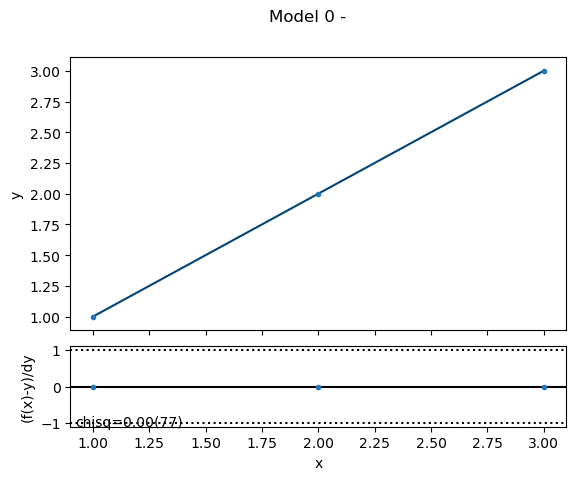

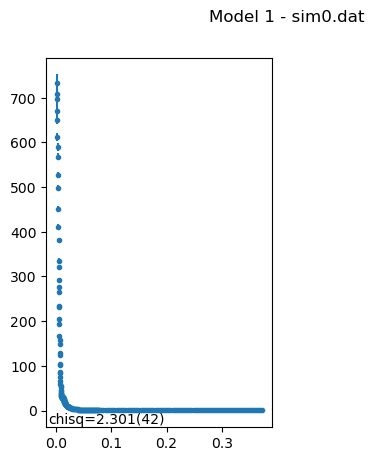

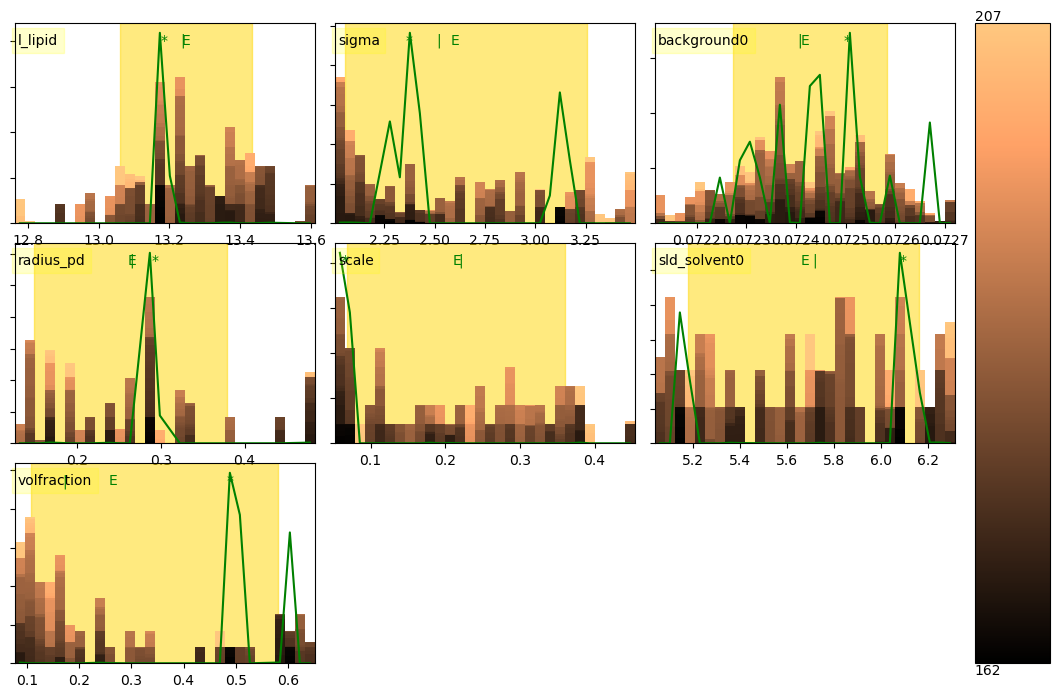

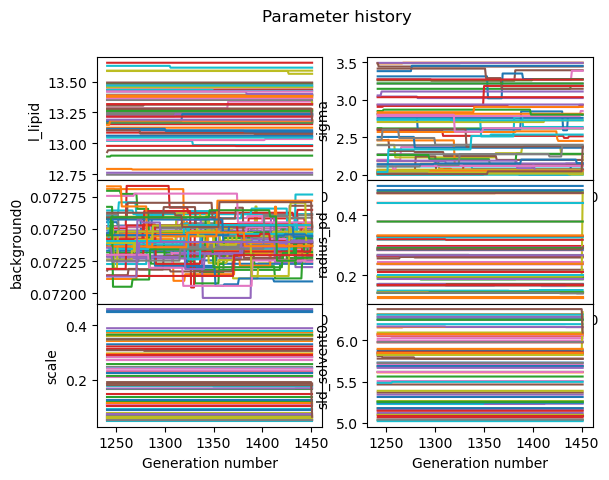

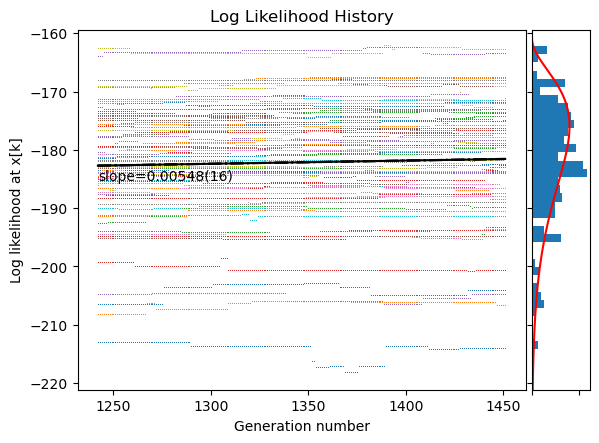

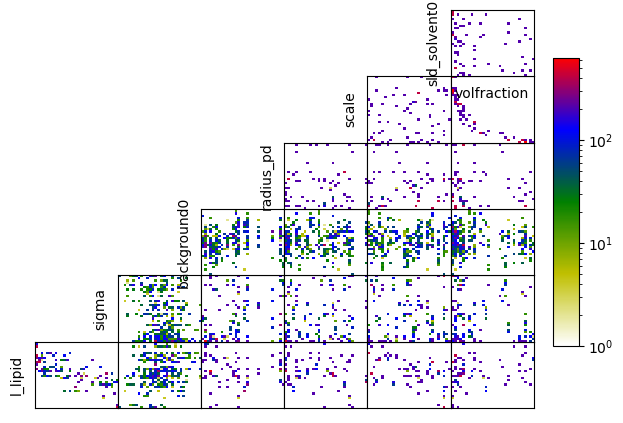

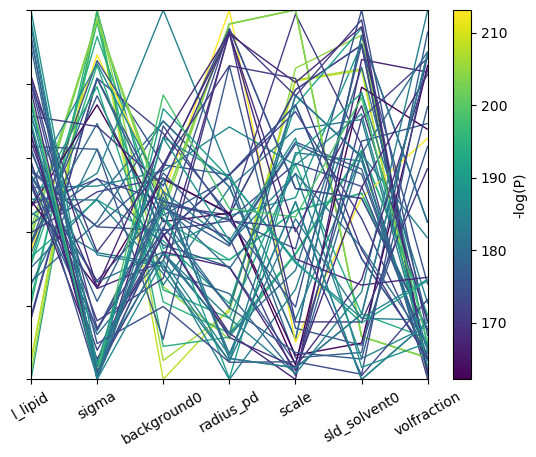

In [4]:
fitobj = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None,
)

if RunFit:
    fitobj.Interactor.fnRunMCMC(burn, steps, batch=False)

print('Restore fit from: ', os.path.join(os.getcwd(), store, runfile))
fitobj.fnRestoreFit()

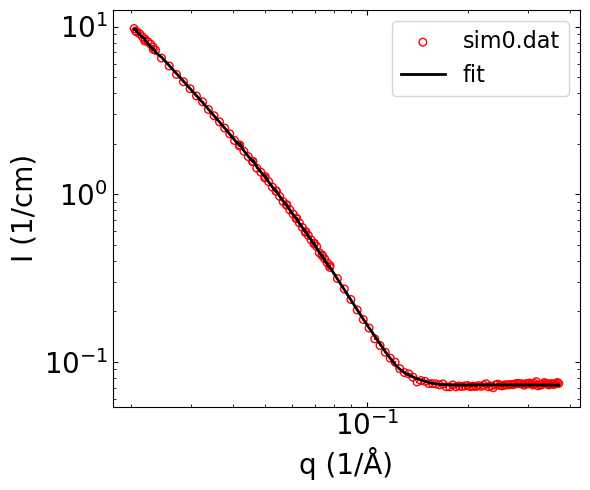

In [5]:
pd = [None, data0.x[(data0.x >= qmin) & (data0.x <= qmax)]]
pd2 = [None, data0.dx[(data0.x >= qmin) & (data0.x <= qmax)]]

i=0
for M in fitobj.Interactor.problem.models:
    M.chisq()
    theo = M.fitness.theory()
    if not isinstance(M.fitness, bumps.curve.Curve):
        fig, ax = plt.subplots()
        ax.errorbar(pd[i], M.fitness.Iq, yerr=M.fitness.dIq, ls='none', color='r')
        ax.scatter(pd[i], M.fitness.Iq, s=30, marker='o', facecolors='none', edgecolors='r', label=M.fitness.name)
        ax.plot(pd[i], theo, label="fit", color='black', linewidth=2)
        ax.legend(loc="upper right", fontsize=16)
        plt.xlabel("q (1/Å)", fontsize=20)
        plt.ylabel("I (1/cm)", fontsize=20)
        ax.minorticks_on()
        ax.tick_params(which="both", direction="in", labelsize=20)
        ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
        ax.set_yscale('log')
        ax.set_xscale('log')
        #plt.xlim(0, 100)
        #plt.ylim(1e-3, 100)
        #plt.xticks(numpy.arange(-35, 36, 5.0))
        #plt.grid(True, which='Both')
        fig.patch.set_facecolor('white')
        ax.figure.set_size_inches(6, 5)
        plt.tight_layout()
        plt.savefig(os.path.join(store, "IvsQ"+str(i)), facecolor="white")
        plt.show()
        numpy.savetxt(os.path.join(store, "IvsQ"+str(i)+".dat"), numpy.c_[pd[i], M.fitness.Iq, M.fitness.dIq, pd2[i], theo], delimiter=' ', header="Q Iq dIq dQ fit")
    i+=1


In [6]:
sparse = 0.05
fitobj.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)

No StatDataPython.dat.
Recreate statistical data from sErr.dat.
Analysis of MCMC fit ...
Number of iterations: 705

Fit Parameters:


,origin,name,vis,lower limit,upper limit,lower percentile,median percentile,upper percentile,interval lower,interval upper,confidence
0,fit,l_lipid,[ +| ],10.0000,15.0,13.047159,13.243335,13.435274,-1.961758e-01,1.919390e-01,0.682689
1,fit,sigma,[| - | ],2.0000,3.5,2.055420,2.538674,3.262467,-4.832534e-01,7.237937e-01,0.682689
2,fit,background0,[ + ],0.0100,0.2,0.072263,0.072416,0.072583,-1.530732e-04,1.666026e-04,0.682689
3,fit,radius_pd,[ | - | ],0.0500,0.5,0.149498,0.262671,0.379209,-1.131731e-01,1.165381e-01,0.682689
4,fit,scale,[ | - | ],0.0001,0.5,0.068771,0.225251,0.359794,-1.564799e-01,1.345429e-01,0.682689
5,fit,sld_solvent0,[ | - | ],5.0000,6.4,5.153555,5.725095,6.158088,-5.715397e-01,4.329936e-01,0.682689
6,fit,volfraction,[ |- | ],0.0100,0.8,0.098789,0.170609,0.528210,-7.182006e-02,3.576007e-01,0.682689
7,bilayer.defect_hg,COM,,NaN,NaN,48.992881,49.212862,49.428092,-2.199809e-01,2.152301e-01,0.682689
8,bilayer.defect_hg,INT,,NaN,NaN,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.682689
9,bilayer.defect_hc,COM,,NaN,NaN,44.205381,44.425362,44.640592,-2.199809e-01,2.152301e-01,0.682689


Create bilayer statistics from above parameter statistics. Results are saved to bilayerplotdata.dat. Plot the median bilayer profile

In [7]:
fitobj.fnProfilesStat()
pandas.DataFrame(fitobj.diStatResults['Molgroups'].keys(), columns=['molecular groups'])

,molecular groups
0,bilayer.defect_hg
1,bilayer.defect_hc
2,bilayer.headgroup1_1
3,bilayer.headgroup1_1.carbonyl_glycerol
4,bilayer.headgroup1_1.choline
5,bilayer.headgroup1_1.phosphate
6,bilayer.headgroup2_1
7,bilayer.headgroup2_1.carbonyl_glycerol
8,bilayer.headgroup2_1.choline
9,bilayer.headgroup2_1.phosphate


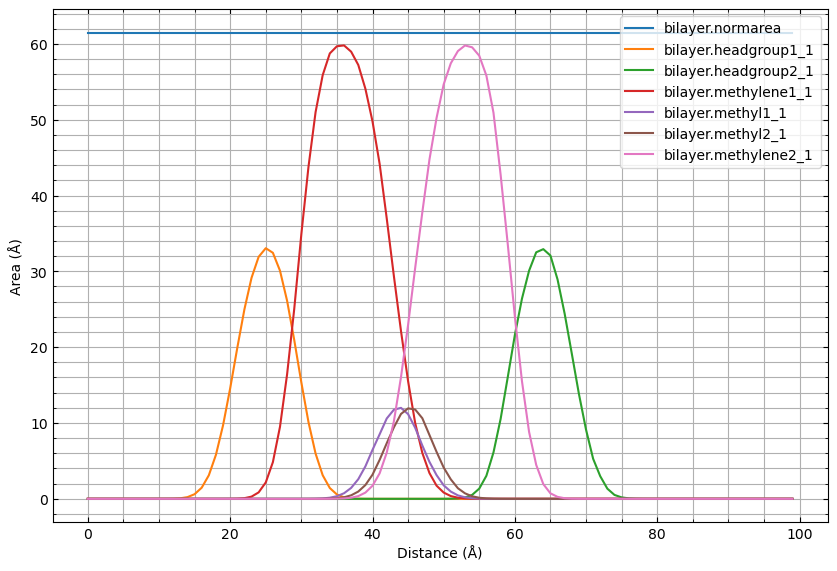

In [9]:
import matplotlib.pyplot as plt

median=['bilayer.normarea', 'bilayer.headgroup1_1', 'bilayer.headgroup2_1', 'bilayer.methylene1_1', 'bilayer.methyl1_1', 'bilayer.methyl2_1', 'bilayer.methylene2_1']
uncertainties=[]

fig, ax = plt.subplots()
for gp in median:
    zaxis = fitobj.diStatResults['Molgroups'][gp]['zaxis']
    area = fitobj.diStatResults['Molgroups'][gp]['median area']
    ax.plot(zaxis, area, label=gp)
    if gp in uncertainties:
        msigma = fitobj.diStatResults['Molgroups'][gp]['msigma area']
        psigma = fitobj.diStatResults['Molgroups'][gp]['psigma area']
        ax.fill_between(zaxis, msigma, psigma, alpha=0.3)

ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Area (Å)")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
#plt.xlim(0, 100)
#plt.xticks(numpy.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(10, 6.66)
plt.savefig(store + "/cvo", facecolor="white")
plt.show()